# Notebook

## Load the sample data

In [46]:
import duckdb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette=sns.color_palette("colorblind"))


DB = "sampled-data/crossref.duckdb"
conn = duckdb.connect(DB)
conn.sql("show tables")

┌─────────┐
│  name   │
│ varchar │
├─────────┤
│ members │
│ works   │
└─────────┘

In [47]:
import numpy as np

def to_numpy(rel):
    col_name = rel.columns[0]
    n = rel.fetchnumpy()
    return np.array(n[col_name])

In [10]:
w_refs_count = conn.table("works").filter("has_refs = True").count("*").fetchone()[0]
wo_refs_count = conn.table("works").filter("has_refs = False").count("*").fetchone()[0]
total_count = conn.table("works").count("*").fetchone()[0]
print(f"""
Sample size:
with references:\t{w_refs_count}
without references:\t{wo_refs_count}
total:\t\t\t{total_count}
""")


Sample size:
with references:	983738
without references:	994380
total:			1978118



## Explore characteristics of works sample

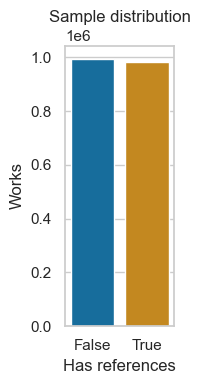

In [44]:
from matplotlib.ticker import ScalarFormatter


fig, (ax) = plt.subplots(1,1, figsize = (2,4))

rel = conn.table("works").aggregate("has_refs, count(*) as count")

sns.barplot(
    ax=ax,
    data=rel.df(),
    x="has_refs",
    hue="has_refs",
    y='count',
    orient="x"
).set_title("Sample distribution")
ax.set_xlabel("Has references")
ax.set_ylabel("Works")
plt.legend([],[], frameon=False)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.ticklabel_format(style='sci', axis='y')

plt.tight_layout()
fig.savefig("vis/sample_has_refs_distribution.png")

In [11]:
type_proportion_sql = """
WITH work_count AS (SELECT work_type, count(*) AS type_count FROM works GROUP BY work_type)

SELECT w.work_type, has_refs as "has references", count(*)/wc.type_count proportion
FROM works w
LEFT JOIN work_count wc ON w.work_type = wc.work_type
GROUP BY (w.work_type, w.has_refs, wc.type_count)
HAVING type_count IS NOT NULL
ORDER BY wc.type_count desc
"""

conn.sql(type_proportion_sql).limit(4)

┌─────────────────┬────────────────┬────────────────────┐
│    work_type    │ has references │     proportion     │
│     varchar     │    boolean     │       double       │
├─────────────────┼────────────────┼────────────────────┤
│ journal-article │ true           │ 0.5839864974730586 │
│ journal-article │ false          │ 0.4160135025269414 │
│ book-chapter    │ true           │ 0.3714946935876236 │
│ book-chapter    │ false          │ 0.6285053064123765 │
└─────────────────┴────────────────┴────────────────────┘

In [13]:
import numpy as np


percentage_labels = [float(round(i,1)) for i in np.linspace(0,1,11)]
percentage_labels

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

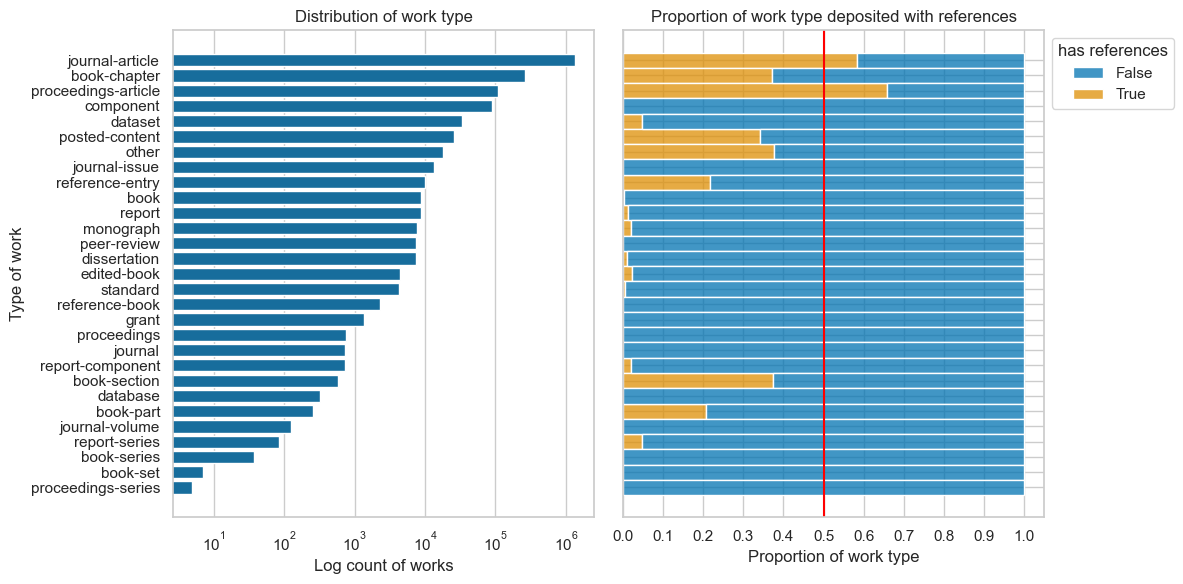

In [35]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (12,6), sharey=True)

df = conn.table("works").aggregate("work_type, count(*) as count").order("count desc").df()
sns.barplot(
    ax=ax1,
    data=df,
    y="work_type",
    x="count",
).set_title("Distribution of work type")
ax1.set_ylabel("Type of work")
ax1.set_xlabel("Log count of works")
ax1.set_xscale("log")

df = conn.sql(type_proportion_sql).df()
sns.histplot(
    ax=ax2,
    data=df,
    y="work_type",
    hue="has references",
    weights='proportion',
    multiple="stack"
).set_title("Proportion of work type deposited with references")
ax2.set_ylabel("Type of work")
ax2.set_xlabel("Proportion of work type")
ax2.set_xticks(np.linspace(0,1,11), labels=percentage_labels)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
plt.axvline(0.5, 0, 1, color='r')

# plt.suptitle("Distribution of sample\nn = 1 978 118")

plt.tight_layout()
fig.savefig("vis/sample_work_type_distribution.png")

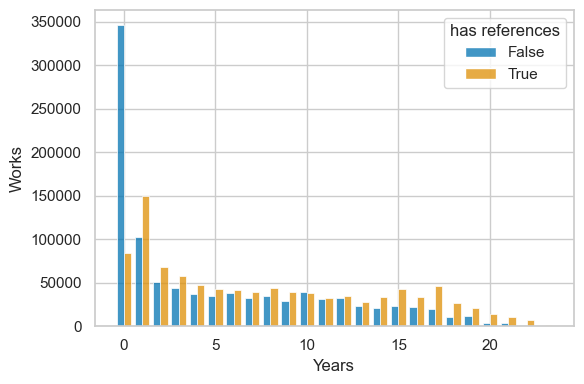

In [217]:
fig, (ax) = plt.subplots(1,1, figsize = (6,4), sharex=True, sharey="row")

df = conn.table("works").select('has_refs as "has references", ceil(deposit_delay_days/365) as delay').df()

sns.histplot(
    ax=ax,
    data=df, 
    x="delay",
    discrete=True,
    hue="has references",
    shrink=.8,
    multiple="dodge"
)#.set_title("Delay between work's creation and deposit")
ax.set_xlabel("Years")
ax.set_ylabel("Works")

plt.tight_layout()
fig.savefig("vis/sample_deposit_delay_per_has_refs.png")

In [39]:
conn.table("works").select('has_refs, ceil(deposit_delay_days/365) as delay').aggregate('has_refs, count(*)')

┌──────────┬──────────────┐
│ has_refs │ count_star() │
│ boolean  │    int64     │
├──────────┼──────────────┤
│ true     │       983738 │
│ false    │       994380 │
└──────────┴──────────────┘

In [68]:
from scipy import stats

rel = conn.sql("""
select 
    case when has_refs = False then 0 else 1 end as has_refs,
    citations_incoming
from works
""")

bools = rel.select("has_refs").fetchnumpy()
bools = np.array(bools['has_refs'])

conts = rel.select("citations_incoming").fetchnumpy()
conts = np.array(conts['citations_incoming'])

# arg1 = array_like of bools
# arg2 = array_like

prb = stats.pointbiserialr(bools, conts)

print(f"""
Point-biserial correlation
Significance result: {prb.statistic}
P-value: {prb.pvalue}
""")
prb


Point-biserial correlation
Significance result: 0.0962778895057796
P-value: 0.0



SignificanceResult(statistic=np.float64(0.0962778895057796), pvalue=np.float64(0.0))

In [108]:
from scipy import stats

rel = conn.sql("""
select 
    citations_incoming,
    citations_outgoing
from works
where has_refs = True
""")

x = rel.select("citations_outgoing").fetchnumpy()
x = np.array(x['citations_outgoing'])

y = rel.select("citations_incoming").fetchnumpy()
y = np.array(y['citations_incoming'])

spr = stats.spearmanr(y, x)

pr = stats.pearsonr(y,x)

print(f"""
Spearman correlation coefficient
Significance result: {spr.statistic}
P-value: {spr.pvalue}

Pearson correlation coefficient
Significance result: {pr.statistic}
P-value: {pr.pvalue}
""")



Spearman correlation coefficient
Significance result: 0.3530306654203059
P-value: 0.0

Pearson correlation coefficient
Significance result: 0.06389336083102433
P-value: 0.0



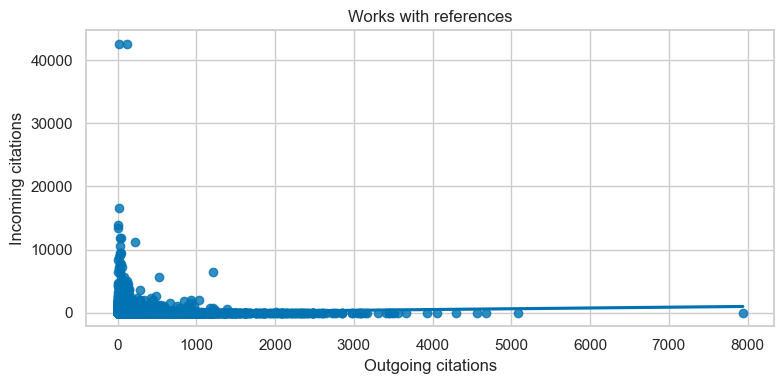

In [107]:
fig, ((ax1)) = plt.subplots(1,1, figsize = (8,4))

df = conn.sql("""
select 
    citations_incoming,
    citations_outgoing
from works
where has_refs = True
""").df()
sns.regplot(
    df, 
    x="citations_outgoing", 
    y="citations_incoming", 
    ax=ax1
).set_title("Works with references")
ax1.set_xlabel("Outgoing citations")
ax1.set_ylabel("Incoming citations")

# df = conn.sql("""
# select 
#     citations_incoming,
#     citations_outgoing
# from works
# where has_refs = True
# and citations_incoming < 5_000
# and citations_outgoing < 5_000
# """).df()
# sns.regplot(
#     df, 
#     x="citations_outgoing", 
#     y="citations_incoming", 
#     ax=ax2
# ).set_title("Excluding outliers, citations < 5000")
# ax2.set_xlabel("Outgoing citations")
# ax2.set_ylabel("Incoming citations")

plt.tight_layout()
fig.savefig("vis/linear_regression.png")

<Axes: xlabel='count', ylabel='ref_deposit_ratio'>

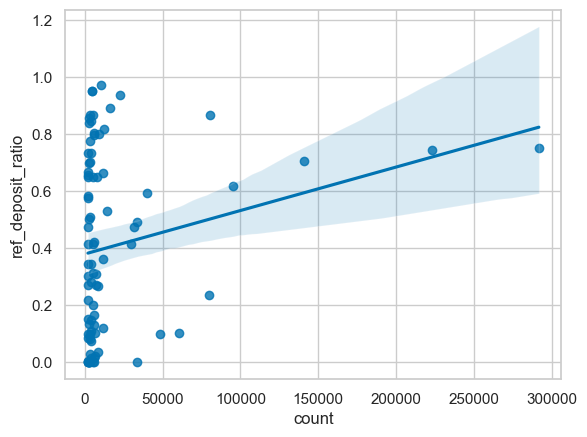

In [64]:
df = conn.sql("""
SELECT 
    w.member, ANY_VALUE(m.name) as name, 
    sum(case when w.has_refs = True then 1 else 0 end)/count(*) as ref_deposit_ratio, 
    count(*) as count
FROM works w
LEFT JOIN members m ON w.member = m.id
GROUP BY w.member
HAVING count > 2_000
ORDER BY count DESC
""").df()
df
sns.regplot(df, x="count", y="ref_deposit_ratio")

<Axes: xlabel='count', ylabel='ref_deposit_ratio'>

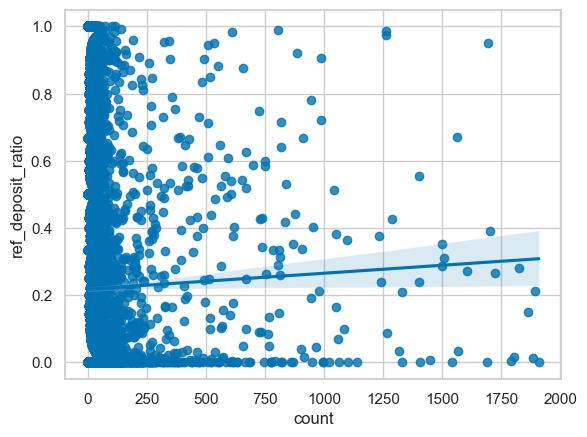

In [65]:
df = conn.sql("""
SELECT 
    w.member, ANY_VALUE(m.name) as name, 
    sum(case when w.has_refs = True then 1 else 0 end)/count(*) as ref_deposit_ratio, 
    count(*) as count
FROM works w
LEFT JOIN members m ON w.member = m.id
GROUP BY w.member
HAVING count < 2_000
ORDER BY count DESC
""").df()
df
sns.regplot(df, x="count", y="ref_deposit_ratio")

In [92]:
sns.color_palette("pastel")[0]

(0.6313725490196078, 0.788235294117647, 0.9568627450980393)

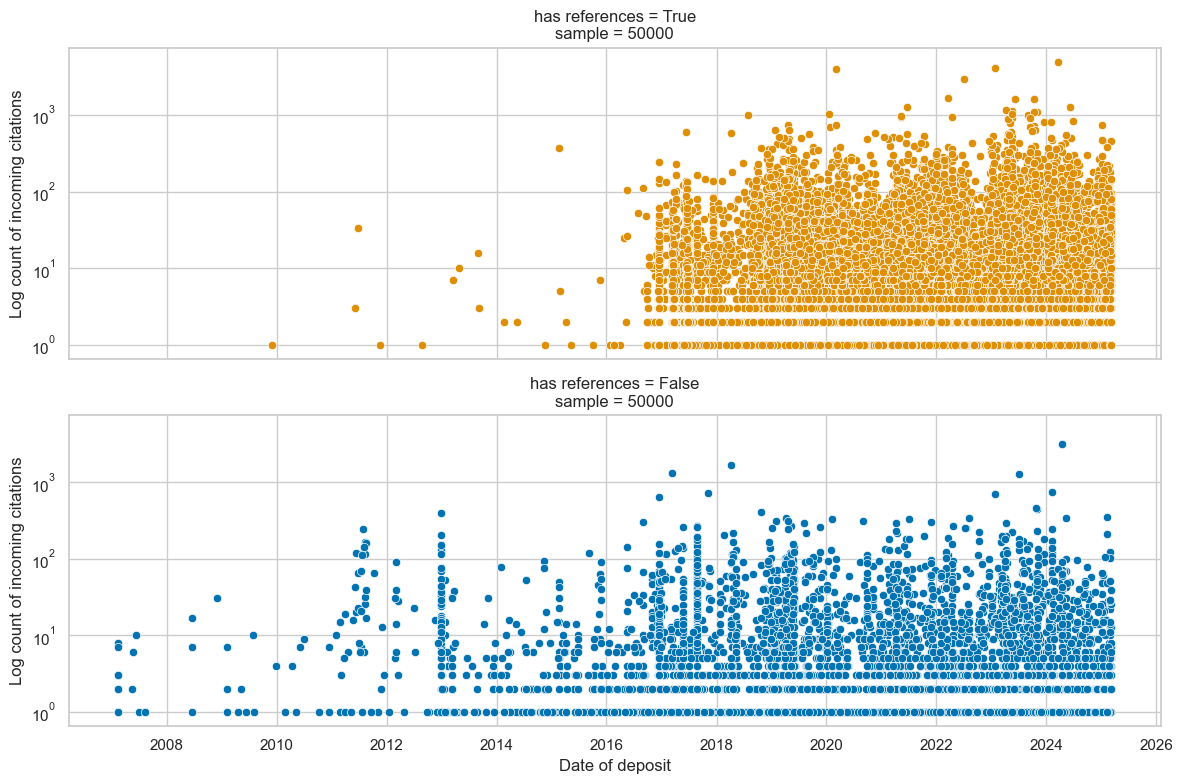

In [126]:
fig, ((ax1, ax2)) = plt.subplots(2,1, figsize = (12,8), sharey=True, sharex=True)


color = sns.color_palette("colorblind")[1]
df = conn.sql("""
SELECT deposited, citations_incoming
FROM works
WHERE has_refs = True
USING SAMPLE 50_000
""").df()
sns.scatterplot(df, x="deposited", y="citations_incoming", ax=ax1, color=color).set_title("has references = True\nsample = 50000")
ax1.set_yscale("log")
ax1.set_xlabel("Date of deposit")
ax1.set_ylabel("Log count of incoming citations")

color = sns.color_palette("colorblind")[0]
df = conn.sql("""
SELECT deposited, citations_incoming
FROM works
WHERE has_refs = False
USING SAMPLE 50_000
""").df()
sns.scatterplot(df, x="deposited", y="citations_incoming", ax=ax2, color=color).set_title("has references = False\nsample = 50000")
ax2.set_yscale("log")
ax2.set_xlabel("Date of deposit")
ax2.set_ylabel("Log count of incoming citations")

plt.tight_layout()

fig.savefig("vis/deposit_date_x_citations.png")

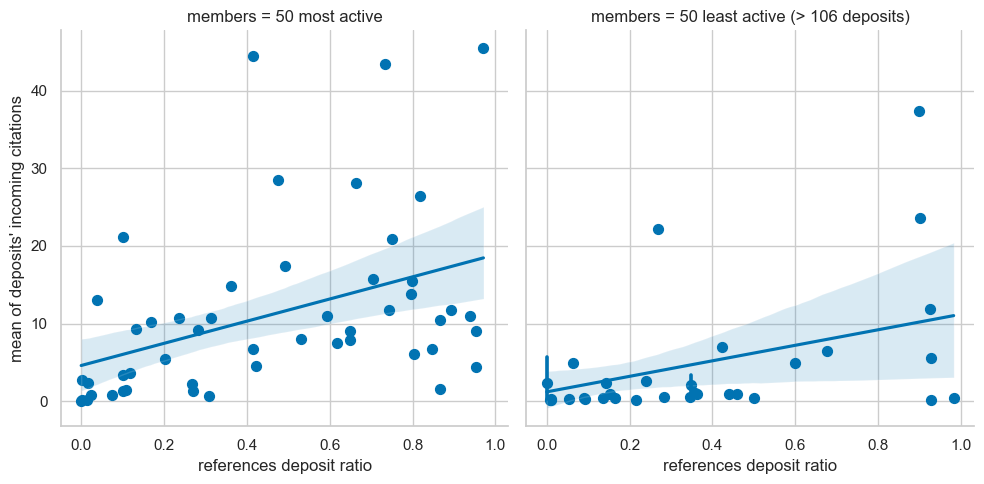

In [369]:
most = """
SELECT '50 most active' as "members", * FROM (
    SELECT
        
        SUM(CASE WHEN w.has_refs = False then 0 else 1 end)/count(*) AS "references deposit ratio",
        mean(citations_incoming) AS "mean of deposits' incoming citations",
        count(*) as "deposits in sample"
    FROM works w
    LEFT JOIN members m ON w.member = m.id
    GROUP BY m.id
    ORDER BY "deposits in sample" DESC
    LIMIT 50
)
"""

least = """
SELECT '50 least active (> 106 deposits)' as "members",  * FROM (
    SELECT
        SUM(CASE WHEN w.has_refs = False then 0 else 1 end)/count(*) AS "references deposit ratio",
        mean(citations_incoming) AS "mean of deposits' incoming citations",
        count(*) as "deposits in sample"
    FROM works w
    LEFT JOIN members m ON w.member = m.id
    GROUP BY m.id
    HAVING "deposits in sample" > 106
    ORDER BY "deposits in sample" ASC
    LIMIT 50
)
"""

sql = f"{most} UNION ALL {least}"

df = conn.sql(sql).df()
df

g = sns.lmplot(
    x='references deposit ratio', 
    y="mean of deposits' incoming citations", 
    col='members', 
    data=df, 
    x_estimator=np.mean)

plt.tight_layout()
# g.savefig("vis/lmplot_members.png")

In [61]:
import numpy as np

YEAR_REFS_PROPORTION = """
    WITH year_count AS (
        SELECT
            year(deposited) AS year,
            count(*) AS count
        FROM works
        GROUP BY year(deposited)
    )

    SELECT
        w.year AS year,
        w.count/yc.count AS proportion,
        yc.count AS total,
        w.count,
        w.has_refs AS "has references"
    FROM (
        SELECT
            count(*) as count,
            year(deposited) as year,
            has_refs
        FROM works
        GROUP BY (year(deposited), has_refs)
    ) w
    LEFT JOIN year_count yc ON w.year = yc.year
    ORDER BY w.year
"""


RELATION = conn.sql(
    f"""
WITH year_prop AS ({YEAR_REFS_PROPORTION})

SELECT
    citations_incoming as "incoming citations",
    case when works.has_refs = False then 0 else 1 end as "has references",
    year(deposited) as year
FROM works
LEFT JOIN year_prop ON year(works.deposited) = year_prop.year
WHERE "has references" IS NOT NULL
ORDER BY year_prop.year
"""
)

def plot_regression(axes:tuple, year: int, rel=RELATION, legend: bool = False):
    ax1, ax2 = axes[0], axes[1]
    
    r = conn.sql(YEAR_REFS_PROPORTION).filter(f"year = {year}")
    a = r.select("total,proportion,year").fetchone()
    total, proportion = a[0], a[1]
    
    sns.regplot(
        ax=ax1,
        x="has references",
        y="incoming citations",
        data=rel.filter(f"year = {year}").df(),
        x_estimator=np.mean,
        ).set_title(f"year = {year}")

    df = r.select('CAST(year AS VARCHAR) AS year, "has references", count').df()
    g = sns.barplot(
        ax=ax2,
        data=df,
        x="year",
        hue="has references",
        y="count",
    )
    if legend:
        sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
    else:
        ax2.get_legend().set_visible(False)


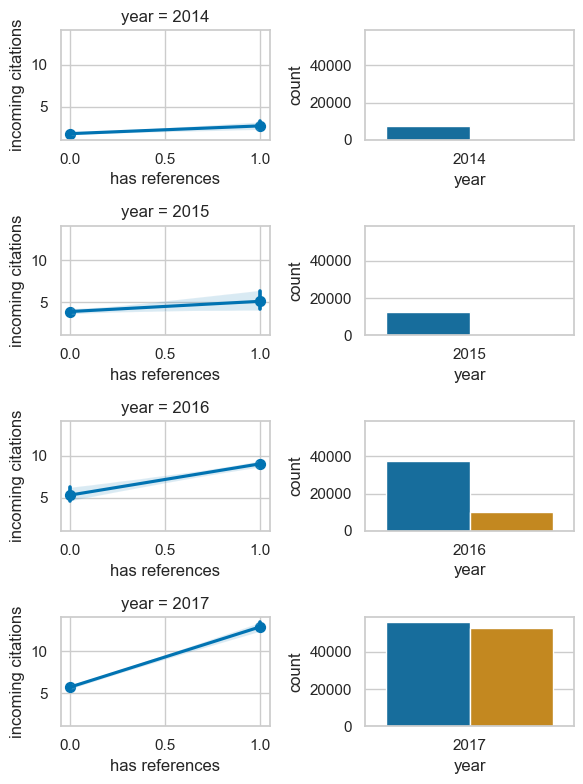

In [62]:
fig, ((axes1),(axes2),(axes3),(axes4)) = plt.subplots(4,2, figsize = (6,8), sharey="col")

plot_regression(axes=axes1, year=2014)
plot_regression(axes=axes2, year=2015)
plot_regression(axes=axes3, year=2016)
plot_regression(axes=axes4, year=2017)


plt.tight_layout()
fig.savefig("vis/regression_2015-2017.png")

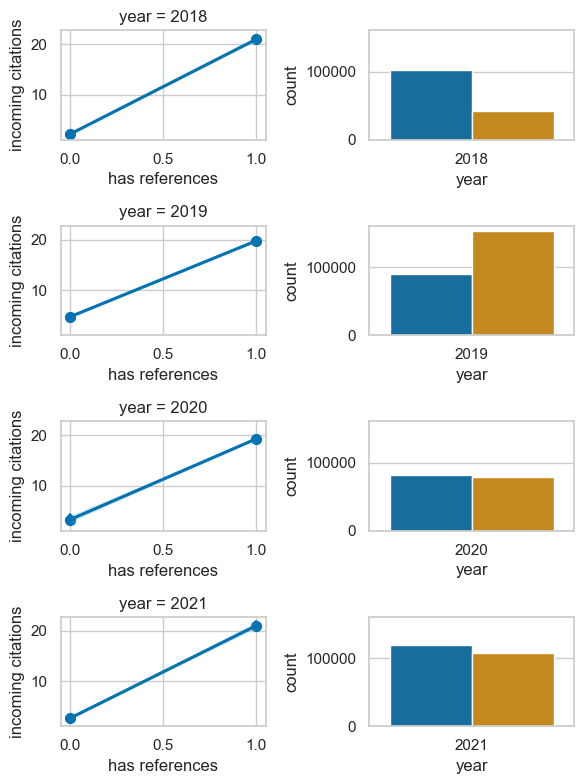

In [63]:
fig, ((axes1),(axes2),(axes3),(axes4)) = plt.subplots(4,2, figsize = (6,8), sharey="col")

plot_regression(axes=axes1, year=2018)
plot_regression(axes=axes2, year=2019)
plot_regression(axes=axes3, year=2020)
plot_regression(axes=axes4, year=2021)


plt.tight_layout()
fig.savefig("vis/regression_2018-2021.png")

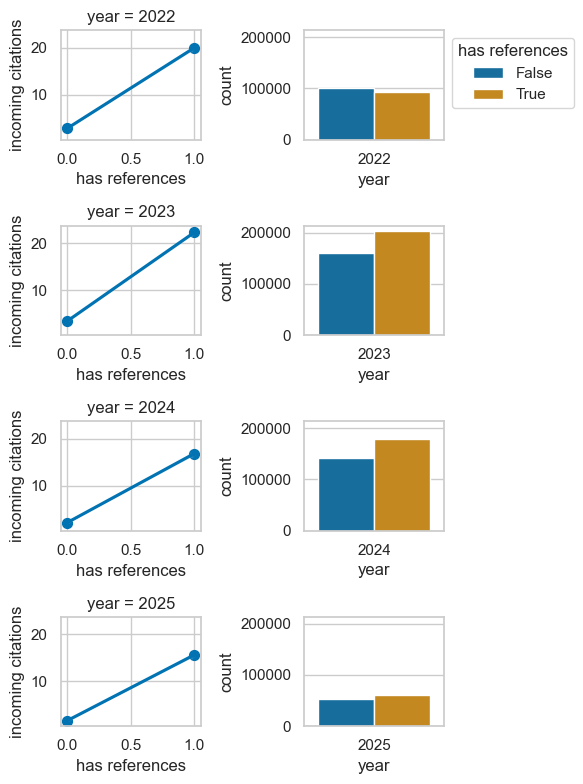

In [64]:
fig, ((axes1),(axes2),(axes3),(axes4)) = plt.subplots(4,2, figsize = (6,8), sharey="col")

plot_regression(axes=axes1, year=2022, legend=True)
plot_regression(axes=axes2, year=2023)
plot_regression(axes=axes3, year=2024)
plot_regression(axes=axes4, year=2025)

plt.tight_layout()
fig.savefig("vis/regression_2022-2025.png")

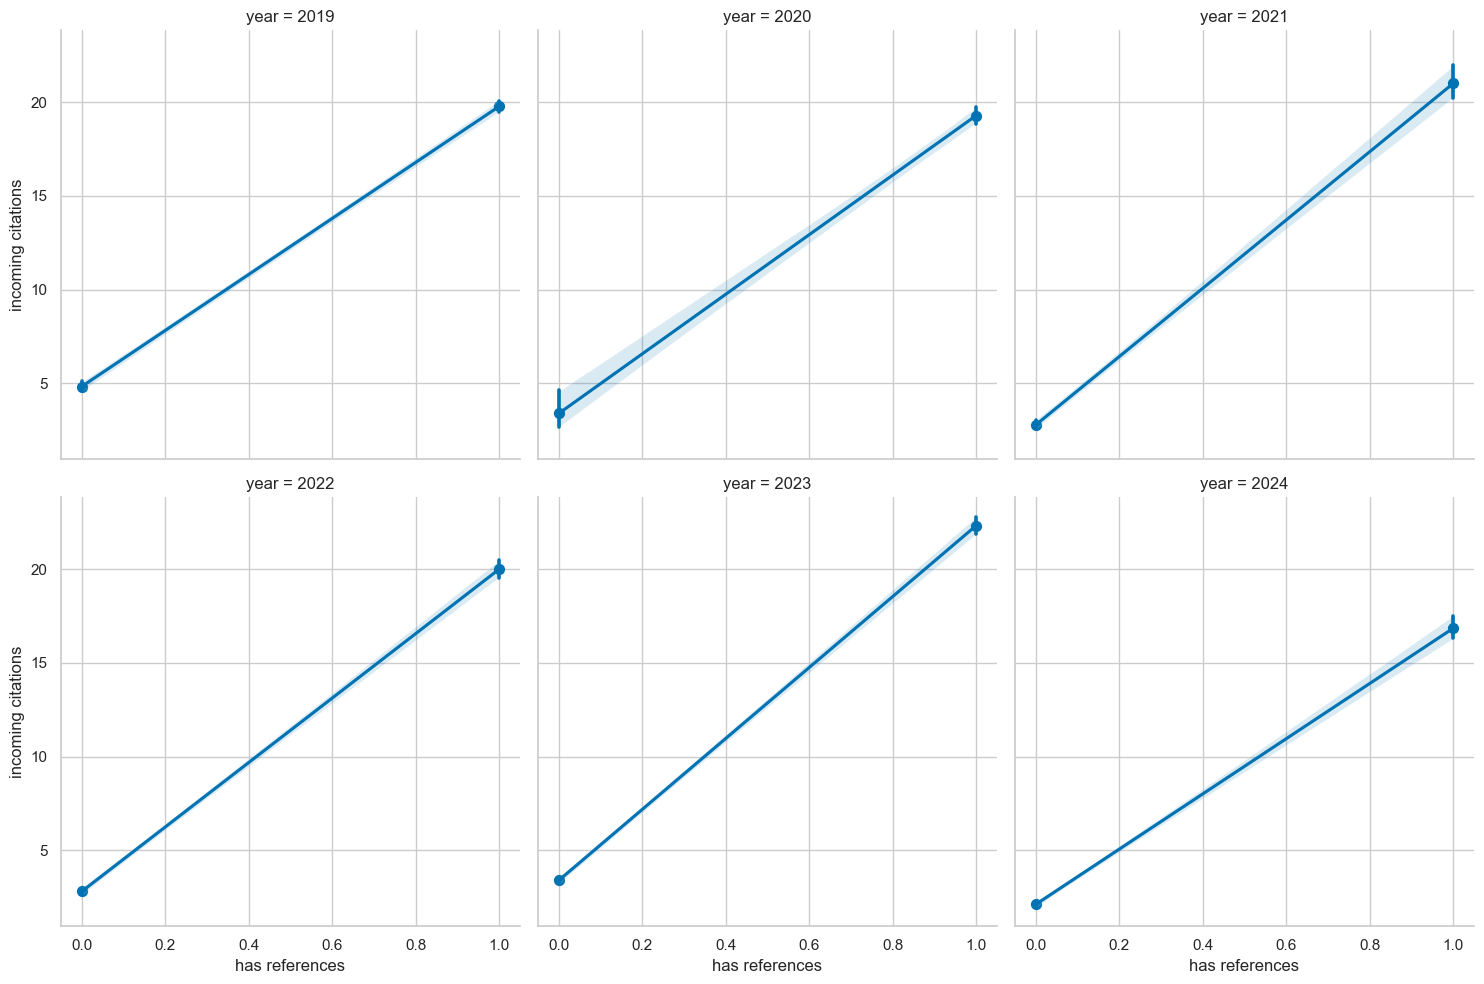

In [ ]:
df = conn.sql("""
SELECT 
    citations_incoming as "incoming citations",
    case when has_refs = False then 0 else 1 end as "has references",
    year(deposited) as year
FROM works
AND "incoming citations" IS NOT NULL
""").df()

df

g = sns.lmplot(
    x="has references", 
    y="incoming citations", 
    col='year', 
    col_wrap=3,
    data=df, 
    x_estimator=np.mean)

plt.tight_layout()
g.savefig("vis/lmplot_works_per_year.png")

In [389]:
conn.sql("""
SELECT 
    citations_incoming as "incoming citations",
    case when has_refs = False then 0 else 1 end as "has references",
    year(deposited) as year
FROM works
WHERE year > 2018
AND year < 2025
AND "incoming citations" IS NOT NULL
AND "has references" = 1
""").count("*")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│       817203 │
└──────────────┘

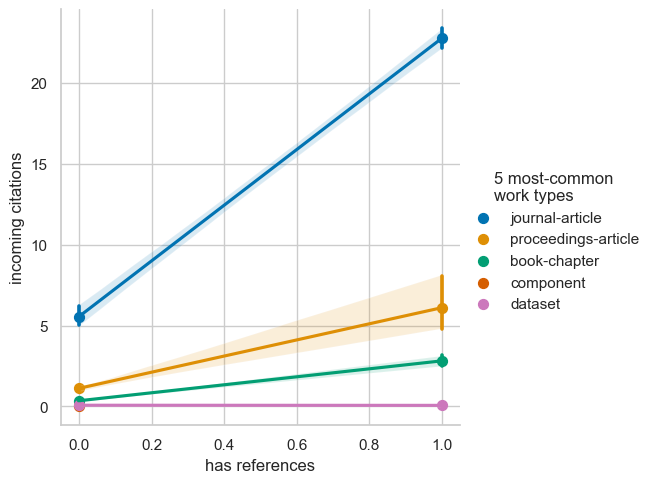

In [395]:
sql = """
WITH types AS (SELECT work_type FROM works GROUP BY work_type ORDER BY count(*) DESC LIMIT 5)

SELECT 
    case when w.has_refs = True then 1 else 0 end as "has references", 
    w.citations_incoming as "incoming citations",
    w.work_type as "work type",
    t.work_type as t_code
FROM works w
LEFT JOIN types t ON w.work_type = t.work_type
WHERE w.citations_incoming IS NOT NULL
AND t_code IS NOT NULL
USING SAMPLE reservoir(200_000 ROWS)
REPEATABLE (100);
"""

df = conn.sql(sql).df()
df

g = sns.lmplot(x="has references", y="incoming citations", hue="work type", data=df, x_estimator=np.mean)

# title
g._legend.set_title("5 most-common\nwork types")

g.savefig("vis/regression_fit.png")

In [396]:
df

,has references,incoming citations,work type,t_code
0,1,7,journal-article,journal-article
1,1,6,journal-article,journal-article
2,0,101,journal-article,journal-article
3,1,209,journal-article,journal-article
4,1,5,journal-article,journal-article
...,...,...,...,...
189086,1,6,journal-article,journal-article
189087,1,68,journal-article,journal-article
189088,0,1,dataset,dataset
189089,0,0,journal-article,journal-article


In [17]:
from scipy import stats

rel = conn.table("works").filter("citations_incoming is not null")

def select_array(has_refs: bool):
    sql = f"""
SELECT citations_incoming
FROM works
WHERE citations_incoming IS NOT NULL
AND has_refs = {has_refs}
    """
    return conn.sql(sql).df()

has_refs = select_array(has_refs=True)
no_refs = select_array(has_refs=False)

levene_homogeneity = stats.levene(has_refs['citations_incoming'], no_refs['citations_incoming'])
shapiro_has_refs = stats.shapiro(has_refs['citations_incoming'], nan_policy="omit")
shapiro_no_refs = stats.shapiro(no_refs['citations_incoming'], nan_policy="omit")

print(f"""
Homogeneity
\tStatistic: {levene_homogeneity.statistic}
\tP-value: {levene_homogeneity.pvalue}
Shapiro
\tStatistic: {shapiro_has_refs.statistic} | {shapiro_no_refs.statistic}
\tP-value: {shapiro_has_refs.pvalue} | {shapiro_no_refs.pvalue}

{shapiro_has_refs}
{shapiro_no_refs}
""")


Homogeneity
	Statistic: 16619.310915322403
	P-value: 0.0
Shapiro
	Statistic: 0.10711386434965664 | 0.018317802510223524
	P-value: 8.609472353420218e-234 | 8.945848533271871e-238

ShapiroResult(statistic=np.float64(0.10711386434965664), pvalue=np.float64(8.609472353420218e-234))
ShapiroResult(statistic=np.float64(0.018317802510223524), pvalue=np.float64(8.945848533271871e-238))



In [7]:
from scipy import stats

rel = conn.sql("SELECT citations_incoming FROM works USING SAMPLE 5000;")
x = to_numpy(rel)

res = stats.shapiro(x)
res.statistic

np.float64(0.044475911071648944)

In [13]:
import pandas as pd
import statsmodels.formula.api as smf

df = conn.table("works").filter("has_refs").select("has_refs, citations_incoming").df()

model = smf.ols('citations_incoming ~ has_refs', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     citations_incoming   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  -0.03332
Date:                Tue, 11 Mar 2025   Prob (F-statistic):               1.00
Time:                        13:51:50   Log-Likelihood:            -5.9249e+06
No. Observations:              983738   AIC:                         1.185e+07
Df Residuals:                  983736   BIC:                         1.185e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.174e+11   1.19e+12  

In [14]:
print(model.fvalue, model.f_pvalue)

-0.033316977645049733 1.0


In [65]:
from scipy import stats

rel = conn.sql("""
select 
    case when has_refs = False then 0 else 1 end as has_refs,
    citations_incoming
from works
where year(deposited) > 2016
""")

bools = rel.select("has_refs").fetchnumpy()
bools = np.array(bools['has_refs'])

conts = rel.select("citations_incoming").fetchnumpy()
conts = np.array(conts['citations_incoming'])

# arg1 = array_like of bools
# arg2 = array_like

prb = stats.pointbiserialr(bools, conts)

print(f"""
Point-biserial correlation
Significance result: {prb.statistic}
P-value: {prb.pvalue}
""")
prb


Point-biserial correlation
Significance result: 0.09732509493314075
P-value: 0.0



SignificanceResult(statistic=np.float64(0.09732509493314075), pvalue=np.float64(0.0))

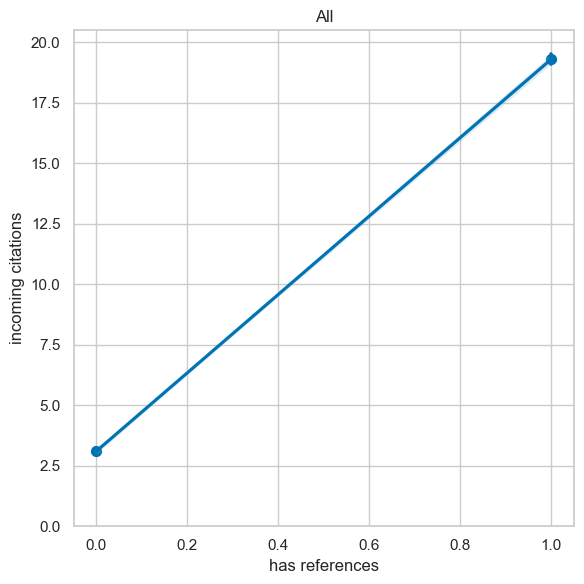

In [74]:
df1 = conn.sql("""
select 
    case when has_refs = False then 0 else 1 end as "has references",
    citations_incoming as "incoming citations"
from works
where year(deposited) > 2016
""").df()

df2 = conn.sql("""
select 
    case when has_refs = False then 0 else 1 end as "has references",
    citations_incoming as "incoming citations"
from works
""").df()

fig, ((ax1)) = plt.subplots(1,1, figsize = (6,6))


sns.regplot(
        ax=ax1,
        x="has references",
        y="incoming citations",
        data=df1,
        x_estimator=np.mean,
        ).set_title("All")
# sns.regplot(
#         ax=ax2,
#         x="has references",
#         y="incoming citations",
#         data=df2,
#         x_estimator=np.mean,
#         ).set_title("year > 2016")

plt.ylim([0, 20.5])
plt.tight_layout()

fig.savefig("vis/regression_of_all_works.png")

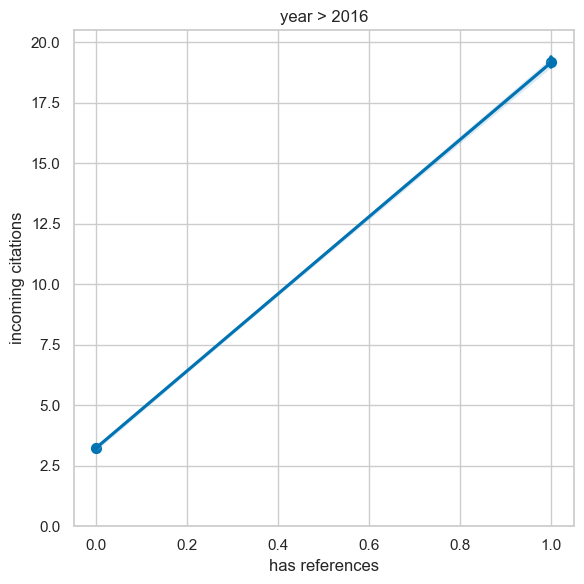

In [73]:
df1 = conn.sql("""
select 
    case when has_refs = False then 0 else 1 end as "has references",
    citations_incoming as "incoming citations"
from works
where year(deposited) > 2016
""").df()

df2 = conn.sql("""
select 
    case when has_refs = False then 0 else 1 end as "has references",
    citations_incoming as "incoming citations"
from works
""").df()

fig, ((ax1)) = plt.subplots(1,1, figsize = (6,6))

sns.regplot(
        ax=ax1,
        x="has references",
        y="incoming citations",
        data=df2,
        x_estimator=np.mean,
        ).set_title("year > 2016")

plt.ylim([0, 20.5])
plt.tight_layout()

fig.savefig("vis/regression_of_works_after_2016.png")

In [71]:
conn.sql("""
select 
    case when has_refs = False then 0 else 1 end as "has references",
    citations_incoming as "incoming citations"
from works
where year(deposited) > 2016
""").describe()

conn.sql("""
select 
    case when has_refs = False then 0 else 1 end as "has references",
    citations_incoming as "incoming citations"
from works
""").describe()

┌─────────┬─────────────────────┬────────────────────┐
│  aggr   │   has references    │ incoming citations │
│ varchar │       double        │       double       │
├─────────┼─────────────────────┼────────────────────┤
│ count   │           1978118.0 │          1976741.0 │
│ mean    │ 0.49731006947007206 │ 11.174772011103125 │
│ stddev  │  0.4999928906023597 │  82.75872170632522 │
│ min     │                 0.0 │                0.0 │
│ max     │                 1.0 │            45239.0 │
│ median  │                 0.0 │                0.0 │
└─────────┴─────────────────────┴────────────────────┘